In [38]:
import pandas as pd
import os
import graphein
path = '../datasets/ALPHAFOLD PDBs/'
import typing_extensions
import pickle

In [ ]:

pdb_files = []
for folder in os.listdir(path):
    # if the folder is a directory
    if os.path.isdir(path + folder):
        # for every file in the folder
        for file in os.listdir(path + folder):
            if 'rank_001' in file and file.endswith('.pdb'):
                pdb_files.append(path + folder + '/' + file)



In [ ]:
pdb_files

In [ ]:
# for each pdb file in pdb_files, get name of the mutation which is the name of the folder before '_'
mutations = []
for pdb in pdb_files:
    mutations.append(pdb.split('/')[-2].split('_')[0])

    

In [ ]:
mutations

In [ ]:
# create a dataframe with the mutation and the pdb file

df = pd.DataFrame({'mutation': mutations, 'pdb_file': pdb_files})

out_path = "../datasets/pdb_files.csv"
if not os.path.isfile(out_path):
    df.to_csv(out_path, index=False)


In [ ]:
from Bio.PDB import PDBParser   
structures = []
parser = PDBParser()
for i, row in df.iterrows():
    structures.append( parser.get_structure(row['mutation'], row['pdb_file']) )
 

In [ ]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph

config = ProteinGraphConfig()
(config.dict())

In [ ]:
graphs = []
for row in df.iterrows():
    graphs.append(construct_graph(path = row[1]['pdb_file'], config= config))

In [25]:
# access coords of each node in the graph
for node in graphs[0].nodes(data=True):
    # node is a tuple with the first element being the node id and the second element being a dictionary with the node attributes
    print

('A:MET:1', {'chain_id': 'A', 'residue_name': 'MET', 'residue_number': 1, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([-13.914, -21.281,   2.359]), 'b_factor': 53.41, 'meiler': dim_1    2.35
dim_2    0.22
dim_3    4.43
dim_4    1.23
dim_5    5.71
dim_6    0.38
dim_7    0.32
Name: MET, dtype: float64})


In [27]:
for node in graphs[0].nodes(data=True):
    # node is a tuple with the first element being the node id and the second element being a dictionary with the node attributes
    print(node[0], node[1]['coords'])
    

A:MET:1 [-13.914 -21.281   2.359]
A:ALA:2 [-1.6891e+01 -2.0453e+01  1.1000e-02]
A:GLU:3 [-15.578 -18.172  -2.83 ]
A:LEU:4 [-16.078 -14.484  -1.752]
A:LYS:5 [-18.047 -12.312  -4.156]
A:TYR:6 [-16.906  -8.906  -5.336]
A:ILE:7 [-18.016  -5.816  -7.199]
A:SER:8 [-15.609  -5.016 -10.055]
A:GLY:9 [-14.375  -1.538 -10.703]
A:PHE:10 [-12.328   1.429  -9.359]
A:GLY:11 [-13.625   4.738  -8.164]
A:ASN:12 [-17.328   3.916  -9.086]
A:GLU:13 [-20.516   4.617  -7.195]
A:CYS:14 [-21.453   1.314  -5.738]
A:SER:15 [-24.109  -0.036  -3.543]
A:SER:16 [-24.297  -3.283  -1.699]
A:GLU:17 [-26.609  -4.945   0.85 ]
A:ASP:18 [-26.281  -8.211   2.67 ]
A:PRO:19 [-28.531 -10.852   1.061]
A:ARG:20 [-29.844 -11.75    4.488]
A:CYS:21 [-31.547  -8.297   4.629]
A:PRO:22 [-32.906  -7.41    1.177]
A:GLY:23 [-34.125  -3.861   0.733]
A:SER:24 [-31.859  -2.494   3.494]
A:LEU:25 [-30.703   0.441   1.321]
A:PRO:26 [-32.875   3.473   1.598]
A:GLU:27 [-34.531   4.383  -1.709]
A:GLY:28 [-34.188   7.945  -3.18 ]
A:GLN:29 [-32.469

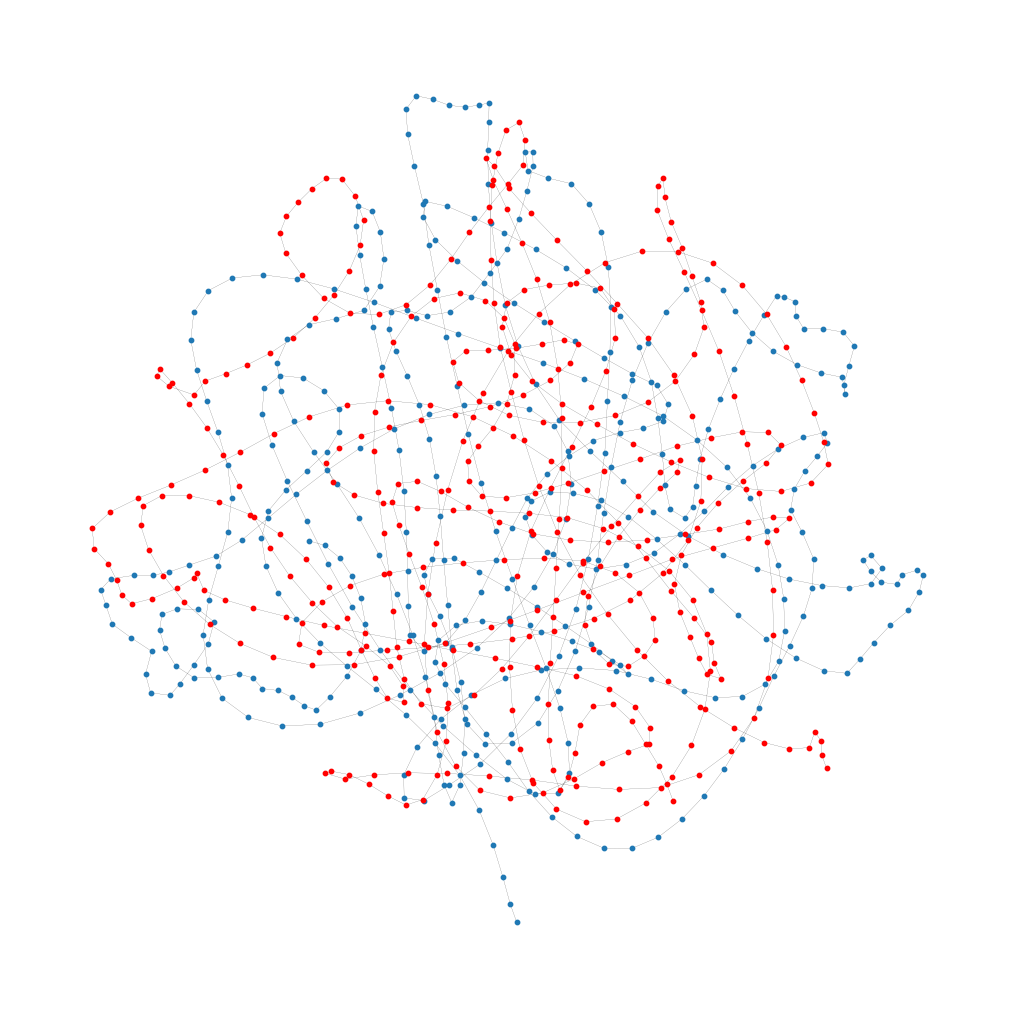

In [32]:
# FIXME: non è la libreria giusta per plottare i grafi, meglio usare graphein 
# plot the graph
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(10, 10))
nx.draw(graphs[0], pos = nx.spring_layout(graphs[0]), node_size=10, width=0.1)
# draw the second grap with red nodes
nx.draw(graphs[1], pos = nx.spring_layout(graphs[1]), node_size=10, width=0.1, node_color='red')
plt.show()

In [40]:
# save the graphs
os.makedirs('../datasets/graphs/', exist_ok=True)
for i, graph in enumerate(graphs):
    mut = df.iloc[i]['mutation']
    with open(f'../datasets/graphs/graph_{mut}.gpickle', 'wb') as f:
        pickle.dump(graph, f)